In [24]:
import numpy as np


p = 1000 # Number of dimensions
c = 1 # Target meanshift is c * M
k = 50 # Number of failuer Mode
nrun_IC = 20 # Number of runs
nrun_OC = 20
n_batch_phase1 = 50 # Number of batches for Phase 1
n_batch_phase2 = 50 # Number of batches for Phase 2
seed_list_IC = np.arange(nrun_IC) # Seeds for number of runs 
seed_list_OC = np.arange(1230,1230+nrun_OC) # 
num_failures = 3
M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
Ks = 5   #Select Top Ks control chart
nsensors = 5 # Number of selected sensors
ARL0 = 500 # Target ARL-IC
Tmax = 2000 # Maximum length

experiment_log = {'p':p, 'c':c, 'k': c, 'nrun_IC':nrun_IC, 'nrum_OC':nrun_OC, 'n_batch_phase1':n_batch_phase1, 'num_failures':num_failures,'Ks':Ks,'nsensors':nsensors,'ARL0':ARL0,'Tmax':Tmax,'L':0,'ARL1':0,'model_name':0,'n_batch_phase2':n_batch_phase2}

In [25]:
experiment_log

{'p': 1000,
 'c': 1,
 'k': 1,
 'nrun_IC': 20,
 'nrum_OC': 20,
 'n_batch_phase1': 50,
 'num_failures': 3,
 'Ks': 5,
 'nsensors': 5,
 'ARL0': 500,
 'Tmax': 2000,
 'L': 0,
 'ARL1': 0,
 'model_name': 0,
 'n_batch_phase2': 50}

## Define data generation Functions

In [26]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    sel_failure_mode = np.random.choice(k, num_failures)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    D1[:,T0:,:] = D1[:,T0:,:]+shift.reshape(1,1,p)
    return D1


In [ ]:
from ExtendedTSSRP import ExtendedTSSRP
from TSSRP import TSSRP
from Oracle import Oracle
from spc.spc import spc
truesensidx = np.arange(nsensors)
nmodels = 4
model_all = [[] for i in range(nmodels)]

# p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode = 'T2'
    
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2',sample_mode = 'mean')
model_all[2] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'cusum')
model_all[3] = TSSRP(p, c, p,M,nsensors,Ks,L=-1,chart='srp',mode='T2')

model_name = ['E_srp_T2','E_srp_mean','E_cusum','srp_T2']
experiment_log['model_name'] = model_name

### Phase I Analysis 

In [28]:
spc_model_all = [[] for i in range(nmodels)]
L = np.zeros(nmodels)


for i in range(nmodels): 
    print(model_name[i], flush=True)
    monitor_statistics = lambda x, T0, L: model_all[i].compute_monitor_batch(x,T0, L)
    spc_model_all[i] = spc(monitor_statistics,data_gen_func0, data_gen_func1)
    L[i] = spc_model_all[i].phase1(n_batch_phase1, Tmax, seed_list_IC,r=1000,ARL0=ARL0)

experiment_log['L'] = L

E_srp_T2


KeyboardInterrupt: 

### Phase II Analysis 


In [17]:
# delta_all =  [0,0.2,0.4,0.6,0.8,1,1.2,1.5,1.8,2,3,4]
delta_all =  [0.4,0.8,1,1.5,2,3,4]
lendelta = len(delta_all)

ARL_all = np.zeros((nmodels,lendelta))
for j,jdelta in enumerate(delta_all):
    print(jdelta)
    for i in range(nmodels): 
        print(model_name[i], flush=True)    
        T_all, RL = spc_model_all[i].phase2( n_batch_phase2, Tmax, seed_list_OC, 20, delta=jdelta)
        ARL_all[i,j] = np.mean(RL)
        print(ARL_all[i,j], flush=True)
experiment_log['ARL1'] = ARL_all

0.4
E_srp_T2
198.0
E_srp_mean
148.0
E_cusum
107.75
srp_T2
46.25
0.8
E_srp_T2
28.0
E_srp_mean
19.75
E_cusum
91.75
srp_T2
39.75
1
E_srp_T2
15.0
E_srp_mean
17.75
E_cusum
95.25
srp_T2
39.0
1.5
E_srp_T2
8.5
E_srp_mean
9.5
E_cusum
91.5
srp_T2
38.0
2
E_srp_T2
7.0
E_srp_mean
9.5
E_cusum
91.25
srp_T2
36.25
3
E_srp_T2
8.25
E_srp_mean
5.25
E_cusum
90.75
srp_T2
35.5
4
E_srp_T2
8.25
E_srp_mean
5.25
E_cusum
90.25
srp_T2
35.0


### Model Logging

In [6]:
import pickle
import time
filename = time.strftime("%Y%b%d_%H%M_exp.pickle", time.localtime())
pickle.dump( experiment_log, open( filename, "wb" ))

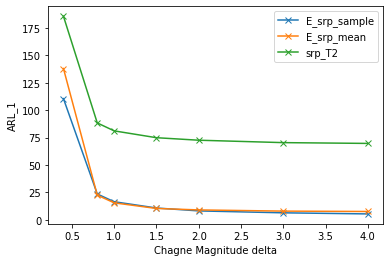

In [10]:
import numpy as np
import pickle
# delta_all =  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.2,1.5,1.8,2,3,4]
delta_all =  [0.4,0.8,1,1.5,2,3,4]
model_name = ['E_srp_sample','E_srp_mean','E_cusum','srp_T2']
experiment_log = pickle.load( open( "2020Mar28_1020_exp.pickle", "rb" ) )
ARL_all_new = experiment_log['ARL1']

#ARL_5 = pickle.load( open( "ARL_5.pickle", "rb" ) )
#ARL_67 = pickle.load( open( "ARL_67.pickle", "rb" ) )
#ARL_all_new = np.concatenate((ARL_all,ARL_5[[5],:]),0)
#ARL_all_new = np.concatenate((ARL_all_new,ARL_67[[6,7],:]),0)
nmodels = 4
import matplotlib.pyplot as plt
%matplotlib inline
for i in [0,1,3]:
    plt.plot(delta_all,ARL_all_new[i,:],'x-',label=model_name[i])
    plt.xlabel('Chagne Magnitude delta')
    plt.ylabel('ARL_1')
    plt.legend()

In [12]:
a = np.array([0,0,1,0,1])
np.where(a)[0]

array([2, 4])